# README
実装の具体的なテクニック、ソースコードについては『ゼロから作るDeep Learning』（オライリージャパン、斎藤康毅著）を参考にしています。  
教師データとしてMNISTデータセットを使用します。  
はじめに1章を実行すると作業ディレクトリにデータセットがpickle形式で保存されます。  
2回目以降は2章以降をRun All Belowにより実行してください。

## 目次
1. **データセットのダウンロードと前処理**（2回目以降はスキップ）  
    1.1 ダウンロード  
    1.2 前処理  
2. **ニューラルネットワークの構築**  
    2.1 データのロード  
    2.2 データのチェック  
    2.3 ネットワークの構成  
    2.4 関数群の定義  
    2.5 誤差逆伝播の実装  
    2.6 ニューラルネットのクラス実装  
3. **ニューラルネットワークの学習（Back Propagation）**  
4. **実験考察**  
    4.1 ハイパーパラメータの変更  
    4.2 ノイズ耐性の検証

# 1. データセットのダウンロードと前処理

## 1.1 ダウンロード
今回は、教師データとして有名な、手書き数字認識学習用の[MNISTデータ](https://qiita.com/yoyoyo_/items/2ef53f47f87dcf5d1e14)を使用します。

In [133]:
# working directryの絶対パス取得
from pathlib import Path
DATA_PATH = str(Path().resolve())

In [134]:
# ダウンロード
import urllib.request

print("MNIST dataset will be downloaded into: \n" + DATA_PATH)
print()

url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

for file_name in key_file.values():
    file_path = DATA_PATH + "/" + file_name
    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")

MNIST dataset will be downloaded into: 
/Users/TAKUMA/Documents/Development/Machine_Learning/deep-learning-from-scratch/self-study/assignment

Done
Done
Done
Done


In [135]:
# データの解凍とNumPy配列への変換
import gzip
import numpy as np

img_size = 784 # 28×28

# ラベルロード用の関数
def load_label(file_name):
    file_path = DATA_PATH + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            # offsetは末尾の余分データをカットするため
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")

    return labels

# 画像ロード用の関数
def load_img(file_name):
    file_path = DATA_PATH + "/" + file_name
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")

    return data
                   

# 各データをnumpy配列へ変換する
def convert_numpy():
    dataset = {}
    dataset['train_img'] =  load_img(key_file['train_img'])
    dataset['train_label'] = load_label(key_file['train_label'])
    dataset['test_img'] = load_img(key_file['test_img'])
    dataset['test_label'] = load_label(key_file['test_label'])

    return dataset

In [136]:
# 以上を実行
dataset = convert_numpy()

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done


## 1.2 前処理

データの前処理として行っておきたいことは以下の3つ。  
1. **正規化(normalize)**: 画像のピクセル値を0.0~1.0に正規化する
2. **one-hot表現**: 数字として表記されているラベルを、0か1のone-hot配列に置き換え
3. **1次元化(flatten)**: 画素値のNumPy配列を1次元に整形する

1次元化については、画像の読み込み時にすでに行っている。

In [137]:
# 正規化とone-hot配列化
print("Normalizing images and translating labels into one-hot ... ")

# 1. normalization
for key in ('train_img', 'test_img'):
    dataset[key] = dataset[key].astype(np.float32)
    dataset[key] /= 255.0
    
# 2. one-hot表現
for key in ('train_label', 'test_label'):
    X = dataset[key]
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    dataset[key] = T
    
print("Done")

Normalizing images and translating labels into one-hot ... 
Done


In [138]:
# pickle形式への保存
import pickle

save_file = DATA_PATH + "/mnist.pkl"
print("Creating pickle file ...")
with open(save_file, 'wb') as f:
    pickle.dump(dataset, f, -1)
print("Done")

Creating pickle file ...
Done


## ----- 以上は初めの1回のみ使用、pickleファイル作成後は2から開始 -----

# 2. ニューラルネットワークの構築

## 2.1 データのロード

In [139]:
def load_mnist():
    # pickleからdatasetのロード
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    print("Dataset successfully loaded!\n")
    
    
load_mnist()
(x_train, t_train), (x_test, t_test) = (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])

Dataset successfully loaded!



In [140]:
# データの形状を確認
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


## 2.2 データのチェック
PILという画像出力のためのモジュールを導入して、これからの画像認識の確認に用います。

In [141]:
from PIL import Image # 画像出力のためのモジュール
import random

# 画像を表示する関数
def img_show(img):
    pil_img = Image.fromarray(np.uint8(img)) # NumPyとして格納された画像データをPIL用のデータオブジェクトに変換
    pil_img.show()
    
img_num = random.randint(0, 60000) # 教師データ60000枚の中からランダムに一枚選ぶ
img = x_train[img_num]
label = t_train[img_num]

print("label: ")
print(label)
img = img.reshape(28, 28)  # 形状を元の画像サイズに変形
img *= 255.0 # 画像表示のため、一旦正規化を解除する
img_show(img) 

label: 
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## 2.3 ネットワークの構成
まず、次のように構成してみる。

* ネットワークは、入力層を784個、出力層を10個のニューロンで構成
    * 入力層の784は、画像サイズの28×28＝784から
    * 出力層の10は、10クラス分類（0から9の10個）


* 隠れ層は1つ
    * 50個、または100個のニューロンを設置


* 活性化関数
    * 出力層には、確率として解釈可能で都合が良いsoftmax関数を用いる
    * 単純化のため、1層目の重みも今回はsoftmax関数を用いてみる
    
    $$ y_k = \frac{\exp(a_k)}{\sum_{i=1}^n\exp(a_i)} $$
    
* 損失関数
    * 一般には**2乗和誤差**
    * 今回はBP学習とsoftmax関数に都合が良い、**交差エントロピー誤差**を用いる
    
    $$ E = - \sum_{k}t_k\log{y_k} $$
    
 
* ミニバッチ学習
    * 損失関数の計算時間短縮のため、60000枚の学習データから、100枚を無作為に選んで繰り返し学習

## 2.4 関数群の定義

In [142]:
# softmax関数の定義
import numpy as np

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

In [143]:
# 損失関数 = 交差エントロピー誤差 の実装
def cross_entropy_error(y, t):
    delta = 1e-7
    batch_size = y.shape[0] # 教師データから無作為に選んだバッチのサイズを取得
    
    return -np.sum(t * np.log(y + delta)) / batch_size # バッチサイズで正規化

## 2.5 誤差逆伝播の実装
これから、誤差逆伝播をレイヤーごとのクラスで実装していく。    
Softmax関数の交差エントロピー誤差の逆伝播は、以下のシンプルな形になることが知られている。  
（確認はレポートにて行う）

$$ E_{backprop} =  y_k - t_k $$

In [144]:
# softmax関数の交差エントロピー誤差の順伝播、逆伝播の実装
class SoftmaxCrossEntropy:
    def __init__(self):
        self.loss = None # 損失の初期化
        self.y = None # softmaxの出力初期化
        self.t = None # 教師データの初期化
        
    # 順伝播 = 損失関数の計算
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    # 逆伝播の実装
    def backward(self, d_out=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size # 逆伝播は出力 - 教師データ
        
        return dx

隠れ層（重み付き和）部分の順伝播、誤差逆伝播の実装

In [145]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b # 重み行列とのドット積計算、バイアスの加算
        
        return out
    
    def backward(self, d_out):
        dx = np.dot(d_out, self.W.T)
        self.dW = np.dot(self.x.T, d_out)
        self.db = np.sum(d_out, axis=0)
        
        return dx

## 2.6 ニューラルネットワークのクラス実装
今回は、入力層、隠れ層1つ、出力層の3層ニューラルネットを構成する。  
これをクラスで管理する。  
重みの初期値設定については、のちに考察するが、まずは参考リンクに倣って、正規分布に0.01をかけたものを設定する。  
参考リンク:[【機械学習】パラメータの重みの初期値](https://qiita.com/m-hayashi/items/02065a2e2ec3e2269e0b)

In [146]:
import numpy as np
from collections import OrderedDict

class NeuralNetwork:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # レイヤーの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxCrossEntropy()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1) # 行方向に最大値を探索
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def bp_learning(self, x, t):
        # forward
        self.loss(x, t)
        
        # backward
        d_out = 1
        d_out = self.lastLayer.backward(d_out)
        
        layers = list(self.layers.values())
        layers.reverse() # listを反転
        for layer in layers:
            d_out = layer.backward(d_out)
            
        # 設定
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

# 3. ニューラルネットワークの学習

In [147]:
import matplotlib.pyplot as plt


def neural_execute(network, iters_num, train_size, batch_size, learning_rate):
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)

    for i in range(iters_num):
        batch_index = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_index]
        t_batch = t_train[batch_index]
    
        grad = network.bp_learning(x_batch, t_batch)
        # 重み、バイアスの更新
        for key in ('W1', 'b1', 'W2', 'b2'):
            network.params[key] -= learning_rate * grad[key]
        
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print(train_acc, test_acc)
        
    markers = {'train': 'o', 'test': 's'}
    x = np.arange(len(train_acc_list))
    plt.plot(x, train_acc_list, label='train acc')
    plt.plot(x, test_acc_list, label='test acc', linestyle='--')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')
    plt.show()

Dataset successfully loaded!

0.06938333333333334 0.0712
0.9043166666666667 0.9094
0.9149 0.9165
0.91525 0.9188
0.9216833333333333 0.9212
0.9202833333333333 0.9185
0.9248166666666666 0.9213
0.92545 0.9226
0.924 0.9206
0.9262833333333333 0.9222
0.92795 0.924
0.9261333333333334 0.9225
0.9279 0.922
0.9283333333333333 0.9227
0.9297666666666666 0.9245
0.9263 0.9207
0.9260666666666667 0.9211


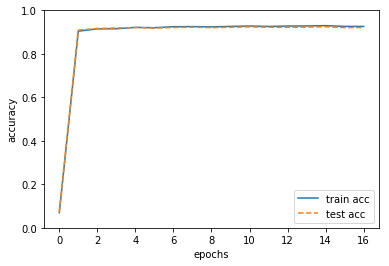

In [148]:
# 誤差逆伝播を用いた学習と分類、汎化能力検証

load_mnist() # データのロード

# 初期設定
network = NeuralNetwork(input_size=784, hidden_size=50, output_size=10)
iters_num = 10000 # 学習の反復回数
train_size = x_train.shape[0]
batch_size = 100 # バッチのサイズ
learning_rate = 0.1 # 学習率

# 実行
neural_execute(network, iters_num, train_size, batch_size, learning_rate)

# 4. 実験考察

## 4.1 ハイパーパラメータの変更と影響
まずはハイパーパラメータによる学習効率の変動を観察してみます。

0.12183333333333334 0.1296
0.9034333333333333 0.9064
0.91445 0.9173
0.9184333333333333 0.9201
0.9195 0.9179
0.92155 0.9189
0.9222833333333333 0.9195
0.9246333333333333 0.9216
0.9272 0.9227
0.923 0.919
0.9260166666666667 0.9221
0.9284666666666667 0.9218
0.9271833333333334 0.923
0.929 0.9244
0.9257 0.919
0.9275666666666667 0.9227
0.9264833333333333 0.9196


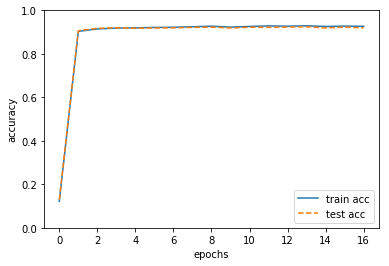

In [149]:
# 隠れ層のニューロンを100個に変更
network = NeuralNetwork(input_size=784, hidden_size=100, output_size=10)
neural_execute(network, iters_num, train_size, batch_size, learning_rate)

0.12906666666666666 0.125
0.9016333333333333 0.9035
0.9137333333333333 0.9153
0.9186 0.9179
0.92135 0.9201
0.9217 0.9223
0.9257833333333333 0.923
0.9241833333333334 0.921
0.9251166666666667 0.923
0.92725 0.9217
0.9267833333333333 0.9241
0.9274333333333333 0.9195
0.9278166666666666 0.925
0.9288 0.9239
0.9287833333333333 0.9237
0.9291333333333334 0.9236
0.9277666666666666 0.9221
0.9300833333333334 0.9243
0.9301666666666667 0.924
0.92835 0.9219
0.93165 0.9242
0.9296666666666666 0.9225
0.9304166666666667 0.9225
0.9295333333333333 0.9241
0.9321166666666667 0.9247
0.9316833333333333 0.9247
0.9308166666666666 0.9223
0.9313833333333333 0.9229
0.9321333333333334 0.9241
0.9314833333333333 0.924
0.9317166666666666 0.9223
0.9312 0.9237
0.9319333333333333 0.926
0.9306166666666666 0.9235


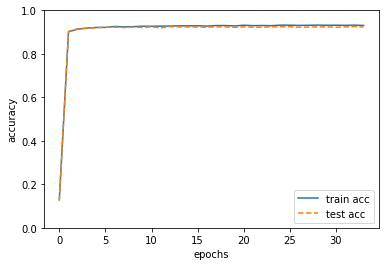

In [150]:
# 学習の反復回数を増やす
network = NeuralNetwork(input_size=784, hidden_size=50, output_size=10)
iters_num = 20000 # 学習の反復回数
neural_execute(network, iters_num, train_size, batch_size, learning_rate)

0.13213333333333332 0.1298
0.9035333333333333 0.9073
0.9120166666666667 0.9129
0.9173333333333333 0.9181
0.9199166666666667 0.92
0.9222 0.9205
0.9223166666666667 0.92
0.9233666666666667 0.921
0.9235333333333333 0.9229
0.9254166666666667 0.9213
0.92605 0.9224
0.9275333333333333 0.9246
0.9263166666666667 0.921
0.9273 0.9217
0.9278333333333333 0.9219
0.928 0.9221
0.9250833333333334 0.9225


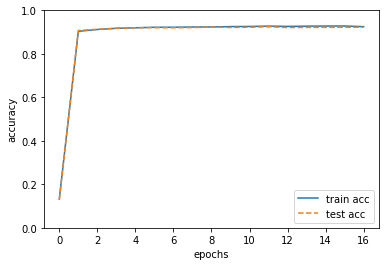

In [151]:
# 重みの初期設定の変更（正規分布に乗算する係数の変更）
network = NeuralNetwork(input_size=784, hidden_size=50, output_size=10, weight_init_std=0.1) # デフォルトは0.01
iters_num = 10000 # 学習の反復回数
neural_execute(network, iters_num, train_size, batch_size, learning_rate)

0.10036666666666667 0.0954
0.8075 0.8122
0.87365 0.8774
0.8918833333333334 0.8953
0.8991166666666667 0.903
0.9047333333333333 0.908
0.9084166666666667 0.9122
0.9104333333333333 0.9122
0.914 0.9157
0.9142666666666667 0.9161
0.9167166666666666 0.9178
0.9168 0.9175
0.9184666666666667 0.9183
0.91955 0.9193
0.92035 0.92
0.9208833333333334 0.9217
0.92225 0.9221


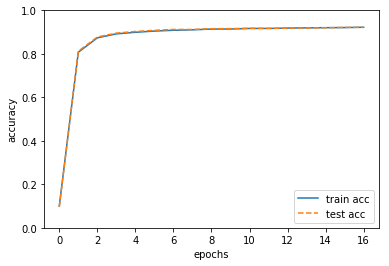

In [169]:
# 学習率を2倍に（0.01 => 0.02)
network = NeuralNetwork(input_size=784, hidden_size=50, output_size=10, weight_init_std=0.01)
neural_execute(network, iters_num, train_size, batch_size, learning_rate=0.02)

## 4.2 ノイズ耐性の実験

In [157]:
# ノイズの付加
import numpy as np

def add_noise(d):
    x_test_noise = np.copy(x_test) # 初期化
    noise_size = d * x_test.shape[1] # 784画素のうち、dの割合をnoiseのsizeとする
    noise = np.random.rand(10000, 784) # x_testと同じ形状のノイズをあらかじめ用意
    for i in range(x_test.shape[0]): # テストデータ1万枚について再帰的にノイズ付加
        noise_index = np.random.choice(x_test.shape[1], int(noise_size))
        for j in noise_index:
            x_test_noise[i][j] = noise[i][j] # index部分のみノイズに置き換え
    
    return x_test_noise

x_test_noise = add_noise(d=0.05)

In [158]:
# ノイズがのったかどうかを画像表示して確認
img = x_test_noise[0] # 10000枚のうち1枚目
img = img.reshape(28, 28)  # 形状を元の画像サイズに変形
img *= 255.0 # 画像表示のため、一旦正規化を解除する
img_show(img)

In [160]:
# ノイズ用のneural network実行関数
def neural_execute_noise(network, iters_num, train_size, batch_size, learning_rate):
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)

    for i in range(iters_num):
        batch_index = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_index]
        t_batch = t_train[batch_index]
    
        grad = network.bp_learning(x_batch, t_batch)
        # 重み、バイアスの更新
        for key in ('W1', 'b1', 'W2', 'b2'):
            network.params[key] -= learning_rate * grad[key]
        
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test_noise, t_test) # ここを変更
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print(train_acc, test_acc)
        
    markers = {'train': 'o', 'test': 's'}
    x = np.arange(len(train_acc_list))
    plt.plot(x, train_acc_list, label='train acc')
    plt.plot(x, test_acc_list, label='test acc', linestyle='--')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')
    plt.show()

In [161]:
# 初期設定
network = NeuralNetwork(input_size=784, hidden_size=50, output_size=10)
iters_num = 10000 # 学習の反復回数
train_size = x_train.shape[0]
batch_size = 100 # バッチのサイズ
learning_rate = 0.1 # 学習率

0.10285 0.107
0.9020666666666667 0.9022
0.9147833333333333 0.9139
0.91555 0.9137
0.9191333333333334 0.9155
0.9206 0.9117
0.9224166666666667 0.9137
0.9256166666666666 0.9127
0.9247166666666666 0.9117
0.9277 0.9109
0.9274666666666667 0.9095
0.9289833333333334 0.9095
0.92415 0.9132
0.926 0.9068
0.9287333333333333 0.9073
0.9285333333333333 0.9071
0.92945 0.9041


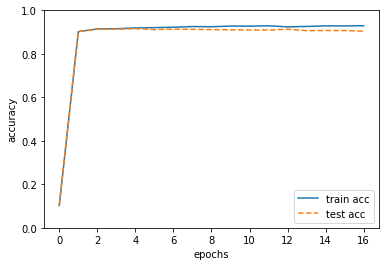

In [162]:
# ノイズ5%での実行
x_test_noise = add_noise(d=0.05)
neural_execute_noise(network, iters_num, train_size, batch_size, learning_rate)

0.08565 0.0863
0.9011666666666667 0.8951
0.9124 0.9036
0.9168166666666666 0.8947
0.9203166666666667 0.8907
0.9217333333333333 0.8962
0.9221 0.8903
0.92495 0.883
0.9251666666666667 0.8668
0.9263833333333333 0.8769
0.9280666666666667 0.872
0.9223333333333333 0.8426
0.9284833333333333 0.8649
0.9295333333333333 0.849
0.93 0.8438
0.9295166666666667 0.8449
0.93115 0.8311


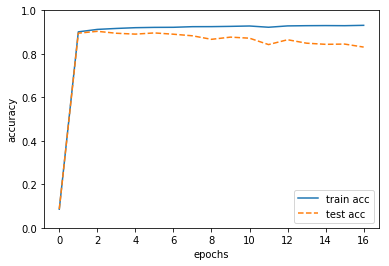

In [165]:
# ノイズ10%での実行
x_test_noise = add_noise(d=0.10)
network = NeuralNetwork(input_size=784, hidden_size=50, output_size=10)
neural_execute_noise(network, iters_num, train_size, batch_size, learning_rate)

0.14248333333333332 0.1328
0.9018666666666667 0.884
0.9143833333333333 0.877
0.9172333333333333 0.8733
0.9206166666666666 0.8587
0.9194 0.8351
0.92195 0.834
0.9235166666666667 0.8516
0.92595 0.8317
0.9257166666666666 0.8024
0.9264666666666667 0.7874
0.9266 0.783
0.9278833333333333 0.767
0.9278666666666666 0.7767
0.9276 0.7419
0.9287 0.7571
0.9296 0.7783


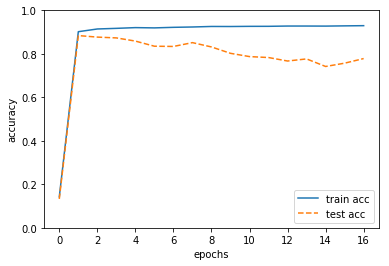

In [166]:
# ノイズ15%での実行
network = NeuralNetwork(input_size=784, hidden_size=50, output_size=10)
x_test_noise = add_noise(d=0.15)
neural_execute_noise(network, iters_num, train_size, batch_size, learning_rate)

0.17675 0.141
0.9024666666666666 0.8429
0.9135 0.8175
0.9190166666666667 0.7715
0.9218666666666666 0.7492
0.9238666666666666 0.6919
0.9236 0.6908
0.9237333333333333 0.6908
0.92685 0.6354
0.9267666666666666 0.6417
0.9274166666666667 0.6136
0.9275166666666667 0.6097
0.9277666666666666 0.5909
0.9239166666666667 0.6148
0.9268333333333333 0.5116
0.9277 0.5612
0.9281166666666667 0.523


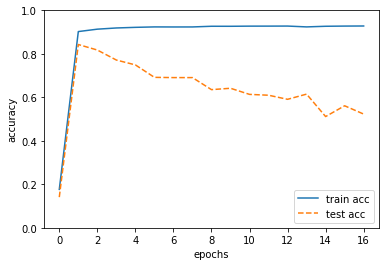

In [167]:
# ノイズ25%での実行
network = NeuralNetwork(input_size=784, hidden_size=50, output_size=10)
x_test_noise = add_noise(d=0.25)
neural_execute_noise(network, iters_num, train_size, batch_size, learning_rate)

0.13 0.1153
0.9022333333333333 0.8533
0.9124333333333333 0.7922
0.91725 0.8006
0.9213166666666667 0.7157
0.9213833333333333 0.7092
0.92545 0.6635
0.9260333333333334 0.6378
0.925 0.5845
0.9256333333333333 0.6294
0.92455 0.6304
0.9269 0.5935
0.9276666666666666 0.6113
0.9279166666666666 0.5738
0.9293666666666667 0.5532
0.9286333333333333 0.5349
0.9293333333333333 0.5486


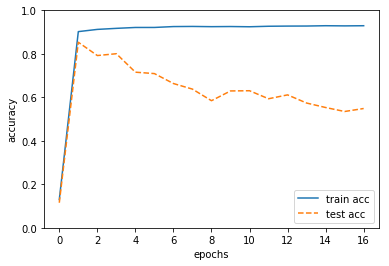

In [168]:
# ノイズ25%で、隠れ層のニューロンを増やしてみる（50個から100個へ）
network = NeuralNetwork(input_size=784, hidden_size=100, output_size=10)
x_test_noise = add_noise(d=0.25)
neural_execute_noise(network, iters_num, train_size, batch_size, learning_rate)